# Parameter inference in DTMCs

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

## DTMC definition in Python
The task of the exercise is to perform parameter inference in a discrete-time Markov chain (DTMC) consisting of 2 states. The transition matrix is given by:

$$
	\begin{bmatrix}
	1-p & p \\
	q & 1-q
	\end{bmatrix}
$$

This notebook provides a Python implementation of the DTMC and simulation/validation of the inference techniques used in the exercise.

In [31]:
# Simulate a Markov chain with a simple transition matrix
class MarkovChain:
	def __init__(self, transition_matrix):
		self.transition_matrix = transition_matrix
		self.states = list(transition_matrix.keys())
		self.current_state = np.random.choice(self.states)

	def next_state(self):
		transitions = self.transition_matrix[self.current_state]
		self.current_state = np.random.choice(
			self.states, 
			p=transitions
		)

	def generate_sequence(self, length):
		sequence = [self.current_state]
		for _ in range(length - 1):
			self.next_state()
			sequence.append(self.current_state)
		return sequence
	
p_true = 0.7
q_true = 0.4
# Example transition matrix for a simple Markov chain
transition_matrix = {
	'A': [1-p_true, p_true],
	'B': [q_true, 1-q_true],
}

In [32]:
# Create a Markov chain instance
markov_chain = MarkovChain(transition_matrix)
# Generate a sequence of states
sequence_length = 10
sequence = markov_chain.generate_sequence(sequence_length)
print("Generated sequence:", sequence)

Generated sequence: [np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('A'), np.str_('A'), np.str_('A'), np.str_('A'), np.str_('B'), np.str_('A')]


## Maximum likelihood estimation (MLE)

In [33]:
def count_AA_sequences(sequences):
	count = sum(
		1 for seq in sequences for i in range(len(seq) - 1) 
		if seq[i] == 'A' and seq[i + 1] == 'A'
	)
	return count

def count_BB_sequences(sequences):
	count = sum(
		1 for seq in sequences for i in range(len(seq) - 1) 
		if seq[i] == 'B' and seq[i + 1] == 'B'
	)
	return count

def count_AB_sequences(sequences):
	count = sum(
		1 for seq in sequences for i in range(len(seq) - 1) 
		if seq[i] == 'A' and seq[i + 1] == 'B'
	)
	return count

def count_BA_sequences(sequences):
	count = sum(
		1 for seq in sequences for i in range(len(seq) - 1) 
		if seq[i] == 'B' and seq[i + 1] == 'A'
	)
	return count


In [34]:
def estimate_transition_probs(chain: MarkovChain, num_chains = 100, sequence_length=20, num_trials=100):
    p_estimates = []
    q_estimates = []

    for _ in range(num_trials):
        sequences = [chain.generate_sequence(sequence_length) for _ in range(num_chains)]

        AA = count_AA_sequences(sequences)
        AB = count_AB_sequences(sequences)
        BB = count_BB_sequences(sequences)
        BA = count_BA_sequences(sequences)

        if AA + AB > 0:
            p_hat = AB / (AA + AB)
        else:
            p_hat = None
        if BB + BA > 0:
            q_hat = BA / (BB + BA)
        else:
            q_hat = None

        if p_hat is not None and q_hat is not None:
            p_estimates.append(p_hat)
            q_estimates.append(q_hat)

    return p_estimates, q_estimates, AA, AB, BB, BA

In [35]:
def confidence_interval(p_hat, n, z=1.96):
	# Calculate the confidence interval for a proportion
	se = (p_hat * (1 - p_hat) / n) ** 0.5
	return p_hat - z * se, p_hat + z * se

In [36]:
def simulate_chains(chain: MarkovChain, num_chains: list|int, sequence_length:list|int, num_trials: int = 100):
	if isinstance(num_chains, int):
		num_chains = [num_chains]
	if isinstance(sequence_length, int):
		sequence_length = [sequence_length]

	results = []
	simulations = []
	for n in num_chains:
		for length in sequence_length:
			p_estimates, q_estimates, n_AA, n_AB, n_BB, n_BA = estimate_transition_probs(chain, n, length, num_trials)
			simulations.append((n, length, p_estimates, q_estimates))
			mean_p = np.mean(p_estimates).item()
			mean_q = np.mean(q_estimates).item()
			ci_p = confidence_interval(mean_p, n_AA + n_AB)
			ci_q = confidence_interval(mean_q, n_BB + n_BA)
			results.append((n, length, p_estimates, ci_p, q_estimates, ci_q))
			
	return results, simulations

In [37]:
def plot_convergence(results, hue, true_p=0.7, true_q=0.4):
	"""
	Plot parameter estimation convergence with confidence intervals.

	Returns:
		matplotlib.figure.Figure object
	"""

	hue_vals = []
	p_means = []
	p_ci_lower = []
	p_ci_upper = []
	q_means = []
	q_ci_lower = []
	q_ci_upper = []

	for result in results:
		n_chains, length, p_estimates, ci_p, q_estimates, ci_q = result
		
		if hue == 'sequence':
			hue_vals.append(length)
		elif hue == 'chains':
			hue_vals.append(n_chains)
		
		p_means.append(np.mean(p_estimates))
		q_means.append(np.mean(q_estimates))
		p_ci_lower.append(ci_p[0])
		p_ci_upper.append(ci_p[1])
		q_ci_lower.append(ci_q[0])
		q_ci_upper.append(ci_q[1])

	# Create the plot
	fig, ax = plt.subplots(figsize=(12, 6))

	ax.plot(hue_vals, p_means, '-o', label='Estimated p', color='tab:blue', linewidth=2)
	ax.plot(hue_vals, q_means, '-s', label='Estimated q', color='tab:orange', linewidth=2)

	ax.fill_between(hue_vals, p_ci_lower, p_ci_upper, color='tab:blue', alpha=0.2, label='p confidence interval')
	ax.fill_between(hue_vals, q_ci_lower, q_ci_upper, color='tab:orange', alpha=0.2, label='q confidence interval')

	ax.axhline(true_p, color='blue', linestyle='--', alpha=0.7, label=f'True p = {true_p}')
	ax.axhline(true_q, color='orange', linestyle='--', alpha=0.7, label=f'True q = {true_q}')

	ax.set_xlabel("Sequence Length" if hue == 'sequence' else "Number of Chains")
	ax.set_ylabel("Estimated Probabilities")
	ax.set_title("Convergence of Parameter Estimates with Confidence Intervals")
	ax.legend()
	ax.grid(True, alpha=0.3)
	fig.tight_layout()
	
	return fig

    
def plot_kde_distributions(simulations, hue, true_p=0.7, true_q=0.4):
	"""
	Plot KDE distributions of parameter estimates.

	Returns:
		matplotlib.figure.Figure object
	"""
	
	sns.set(style="whitegrid")
	palette = sns.color_palette("tab10", n_colors=len(simulations))
	fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

	for i, (n_chains, length, p_estimates, q_estimates) in enumerate(simulations):
		label = f'Length={length}' if hue == 'sequence' else f'Chains={n_chains}' if hue == 'chains' else f'Length={length}, Chains={n_chains}'
		sns.kdeplot(p_estimates, ax=axes[0], label=label, color=palette[i], fill=True, linewidth=2)
		sns.kdeplot(q_estimates, ax=axes[1], label=label, color=palette[i], fill=True, linewidth=2)

	axes[0].axvline(true_p, color='black', linestyle='--', label=f'True p = {true_p}')
	axes[0].set_title("KDE of p Estimates")
	axes[0].set_xlabel("Estimated p")
	axes[0].set_ylabel("Density")
	axes[0].legend(title="Sequence Length" if hue == 'sequence' else "Number of Chains" if hue == 'chains' else "Length and Chains")
	axes[0].grid(True)

	axes[1].axvline(true_q, color='black', linestyle='--', label=f'True q = {true_q}')
	axes[1].set_title("KDE of q Estimates")
	axes[1].set_xlabel("Estimated q")
	axes[1].legend(title="Sequence Length" if hue == 'sequence' else "Number of Chains" if hue == 'chains' else "Length and Chains")
	axes[1].grid(True)

	fig.suptitle("KDEs of Transition Probability Estimates", fontsize=16)
	fig.tight_layout(rect=[0, 0, 1, 0.95])

	return fig



In [38]:
sequence_lengths = [10, 50, 100, 250, 500]
num_chains = 100
num_trials = 100

results, simulations = simulate_chains(markov_chain, num_chains, sequence_lengths, num_trials)

In [39]:
# Print for each sequence length the MLE estimates and confidence intervals
for n_chains, length, p_estimates, ci_p, q_estimates, ci_q in results:
	print(f"Chains: {n_chains}, Length: {length}")
	print(f"  Estimated p: {np.mean(p_estimates).item():.4f}, CI: {ci_p}")
	print(f"  Estimated q: {np.mean(q_estimates).item():.4f}, CI: {ci_q}")

Chains: 100, Length: 10
  Estimated p: 0.7036, CI: (0.6545845542925587, 0.7526807401438883)
  Estimated q: 0.3974, CI: (0.3571017046994789, 0.43766173689349464)
Chains: 100, Length: 50
  Estimated p: 0.6979, CI: (0.6766039227193246, 0.7191249282664822)
  Estimated q: 0.4003, CI: (0.3830357715721231, 0.41748649688380335)
Chains: 100, Length: 100
  Estimated p: 0.7007, CI: (0.6856302025919827, 0.71572639338191)
  Estimated q: 0.4005, CI: (0.38840855567887805, 0.41252776522964646)
Chains: 100, Length: 250
  Estimated p: 0.7003, CI: (0.6908192941487535, 0.7096811435768985)
  Estimated q: 0.3999, CI: (0.39226654818857026, 0.40752736259104955)
Chains: 100, Length: 500
  Estimated p: 0.6997, CI: (0.6930210845336399, 0.7063254594737677)
  Estimated q: 0.3996, CI: (0.3942514574859121, 0.4050430614246899)


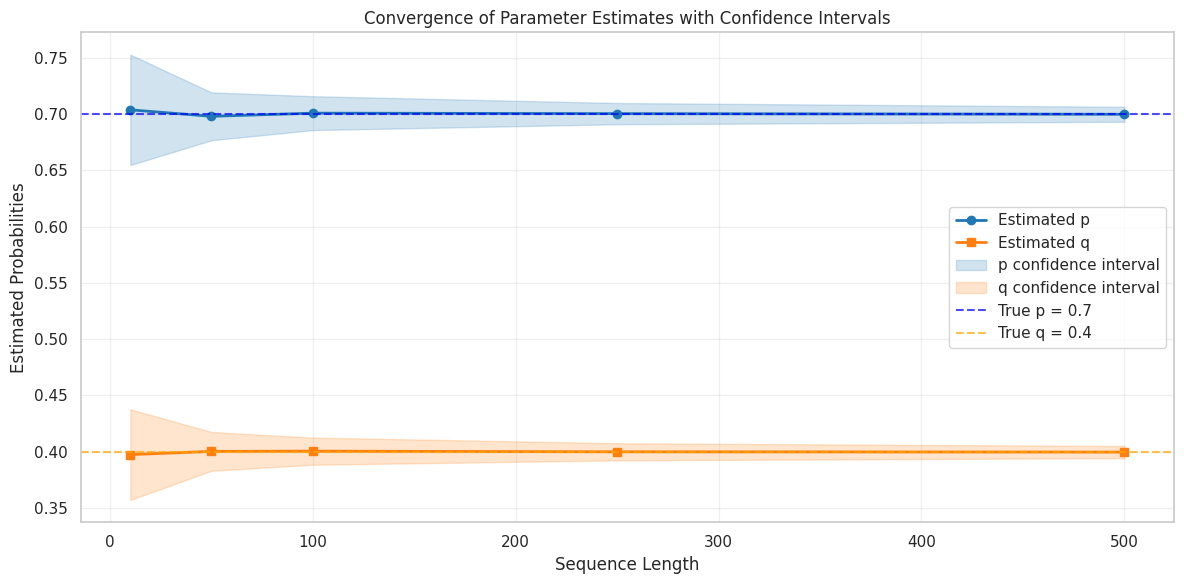

In [40]:
fig = plot_convergence(results, hue = 'sequence', true_p=p_true, true_q=q_true)
fig.savefig("plots/convergence_plot_MLE_sequences.png", dpi=300)

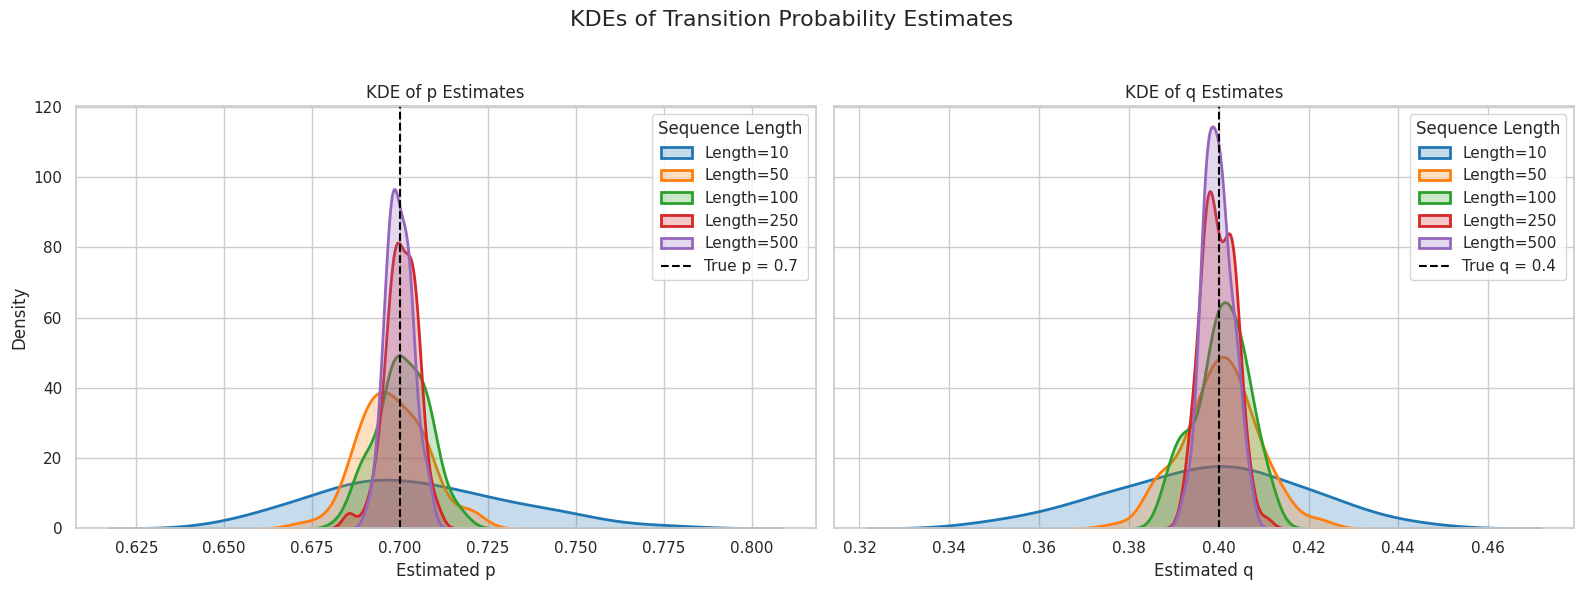

In [41]:
fig = plot_kde_distributions(simulations, hue='sequence', true_p=p_true, true_q=q_true)
fig.savefig("plots/kde_distributions_MLE_sequences.png", dpi=300)

In [42]:
sequence_lengths = 100
num_chains = [10, 50, 100, 250, 500]
num_trials = 100

results, simulations = simulate_chains(markov_chain, num_chains, sequence_lengths, num_trials)

In [43]:
# Print for each sequence length the MLE estimates and confidence intervals
for n_chains, length, p_estimates, ci_p, q_estimates, ci_q in results:
	print(f"Chains: {n_chains}, Length: {length}")
	print(f"  Estimated p: {np.mean(p_estimates):.4f}, CI: {ci_p}")
	print(f"  Estimated q: {np.mean(q_estimates):.4f}, CI: {ci_q}")

Chains: 10, Length: 100
  Estimated p: 0.6992, CI: (0.6519727331130847, 0.7463335416126713)
  Estimated q: 0.4005, CI: (0.3621491179456036, 0.43885856314514754)
Chains: 50, Length: 100
  Estimated p: 0.7001, CI: (0.6790303175968312, 0.7211345652769022)
  Estimated q: 0.4000, CI: (0.382851272690284, 0.41717718539919096)
Chains: 100, Length: 100
  Estimated p: 0.6993, CI: (0.684355945372603, 0.7142734178866493)
  Estimated q: 0.3982, CI: (0.3860779671488619, 0.41027337654254636)
Chains: 250, Length: 100
  Estimated p: 0.7003, CI: (0.6908324451539445, 0.7097085101440312)
  Estimated q: 0.4007, CI: (0.39303361133624753, 0.4083654992228974)
Chains: 500, Length: 100
  Estimated p: 0.6997, CI: (0.6930516701934877, 0.7064438612116801)
  Estimated q: 0.3999, CI: (0.3945278628891345, 0.4053479826476795)


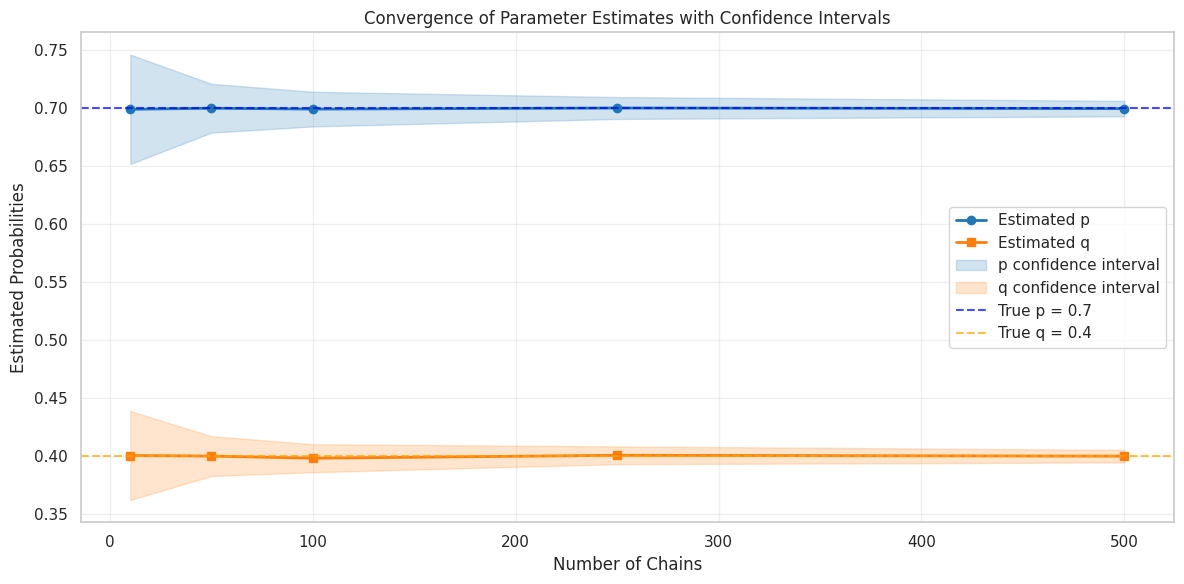

In [44]:
fig = plot_convergence(results, hue='chains', true_p=p_true, true_q=q_true)
fig.savefig("plots/convergence_plot_MLE_chains.png", dpi=300)

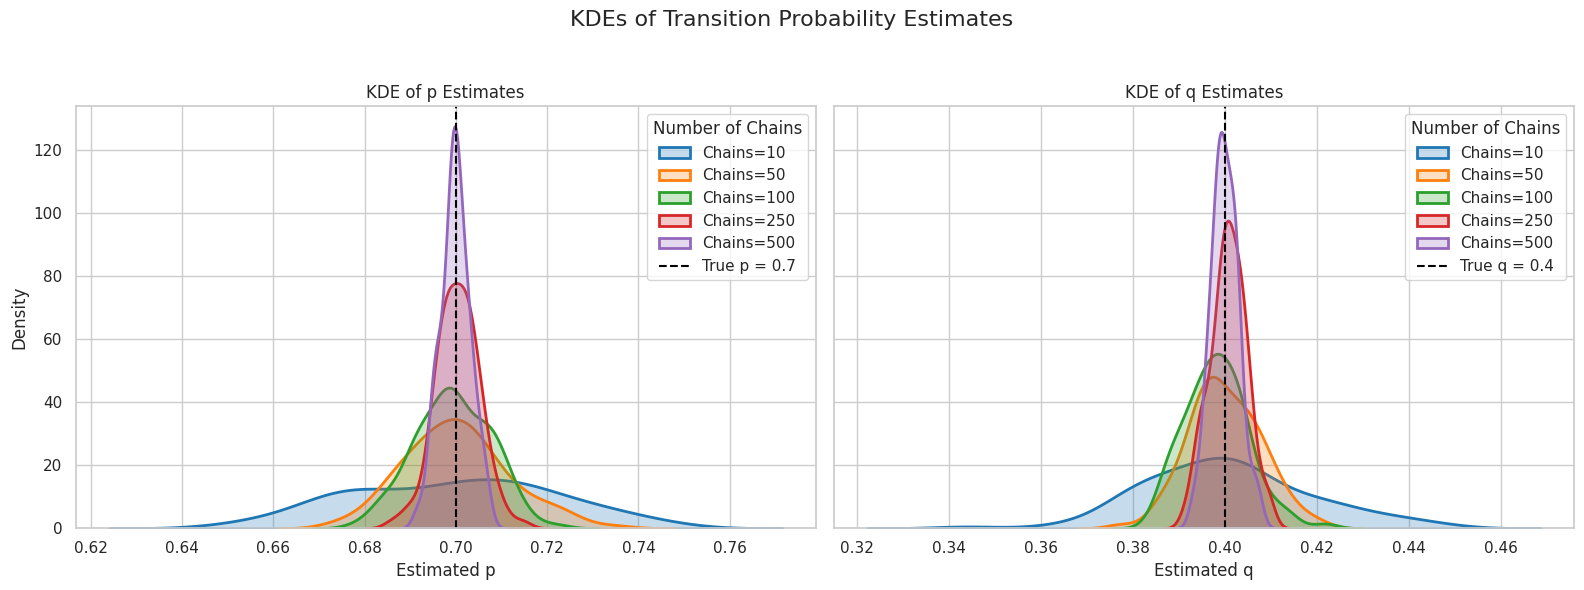

In [45]:
fig = plot_kde_distributions(simulations, hue='chains', true_p=p_true, true_q=q_true)
fig.savefig("plots/kde_plot_MLE_chains.png", dpi=300)

# Bayesian Estimation

In [18]:
alpha_prior_p, beta_prior_p = 1, 1
alpha_prior_q, beta_prior_q = 1, 1

In [19]:
def compute_posterior(alpha_prior_p, beta_prior_p, 
                      alpha_prior_q, beta_prior_q,
                      num_chains, sequence_length, num_trials=100):
    
	
	if isinstance(num_chains, int):
		num_chains = [num_chains]
	if isinstance(sequence_length, int):
		sequence_length = [sequence_length]

	posterior_p = []
	posterior_q = []

	for n in num_chains:
		for length in sequence_length:
			_, _, n_AA, n_AB, n_BB, n_BA = estimate_transition_probs(markov_chain, n, length, num_trials)
			
			# Update the posterior parameters
			alpha_post_p = alpha_prior_p + n_AB
			beta_post_p = beta_prior_p + n_AA
			alpha_post_q = alpha_prior_q + n_BA
			beta_post_q = beta_prior_q + n_BB

			# Compute the posterior distributions
			posterior_p.append((alpha_post_p, beta_post_p))
			posterior_q.append((alpha_post_q, beta_post_q))
			
	return posterior_p, posterior_q

In [20]:
def credibility_interval(alpha_post, beta_post):
	# Calculate the credibility interval for a beta distribution
	lower_bound = beta.ppf(0.025, alpha_post, beta_post).item()
	upper_bound = beta.ppf(0.975, alpha_post, beta_post).item()
	return lower_bound, upper_bound

In [21]:
def plot_posterior_distribution(posterior_p, posterior_q, hue, true_p=0.7, true_q=0.4):
	"""
	Plot the posterior distributions of p and q.
	
	Args:
		posterior_p: List of tuples (alpha, beta) for p posterior
		posterior_q: List of tuples (alpha, beta) for q posterior
		true_p: True value of parameter p
		true_q: True value of parameter q
	"""
	x_p = np.linspace(true_p - 0.1, true_p + 0.1, 300)
	x_q = np.linspace(true_q - 0.1, true_q + 0.1, 300)
    
    # Create color palette
	palette = sns.color_palette('tab10', n_colors=len(posterior_p))

	# Create subplots
	fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

	# Plot posterior for p
	for i, (a, b) in enumerate(posterior_p):
		pdf = beta.pdf(x_p, a, b)
		axes[0].fill_between(x_p, pdf, label=f'Length={sequence_lengths[i]}' if hue == 'sequence' else f'Chains={num_chains[i]}' if hue == 'chains' else f'Length={sequence_lengths[i]}, Chains={num_chains[i]}',
			color=palette[i], alpha=0.3)
		axes[0].plot(x_p, pdf, color=palette[i])

	axes[0].axvline(true_p, linestyle='--', color='k', label=f'True p = {p_true}')
	axes[0].set_title("Posterior of p = P(A → B)")
	axes[0].set_xlabel("p")
	axes[0].set_ylabel("Density")
	axes[0].legend(title="Sequence Length" if hue == 'sequence' else "Number of Chains" if hue == 'chains' else "Length and Chains")
	axes[0].grid(True)

	# Plot posterior for q
	for i, (a, b) in enumerate(posterior_q):
		pdf = beta.pdf(x_q, a, b)
		axes[1].fill_between(x_q, pdf, label=f'Length={sequence_lengths[i]}' if hue == 'sequence' else f'Chains={num_chains[i]}' if hue == 'chains' else f'Length={sequence_lengths[i]}, Chains={num_chains[i]}',
			color=palette[i], alpha=0.3)
		axes[1].plot(x_q, pdf, color=palette[i])

	axes[1].axvline(true_q, linestyle='--', color='k', label=f'True q = {q_true}')
	axes[1].set_title("Posterior of q = P(B → A)")
	axes[1].set_xlabel("q")
	axes[1].legend(title="Sequence Length" if hue == 'sequence' else "Number of Chains" if hue == 'chains' else "Length and Chains")
	axes[1].grid(True)

	# Add overall title and adjust layout
	plt.suptitle("Bayesian Posterior Densities Across Sequence Lengths", fontsize=16)
	plt.tight_layout(rect=[0, 0, 1, 0.95])

	return fig, axes

In [22]:
sequence_lengths = [10, 50, 100, 250, 500]
num_chains = 100

In [23]:
posterior_p, posterior_q = compute_posterior(
	alpha_prior_p, beta_prior_p, 
	alpha_prior_q, beta_prior_q, 
	num_chains, sequence_lengths)

In [24]:
# Print for each sequence length the MAP estimate and credibility interval
for i, length in enumerate(sequence_lengths):
	alpha_p, beta_p = posterior_p[i]
	alpha_q, beta_q = posterior_q[i]
	
	credibility_p = credibility_interval(alpha_p, beta_p)
	credibility_q = credibility_interval(alpha_q, beta_q)
	
	print(f"Sequence Length {length}:")
	print(f"  MAP estimate for p: {alpha_p / (alpha_p + beta_p):.3f}, Credibility Interval: {credibility_p}")
	print(f"  MAP estimate for q: {alpha_q / (alpha_q + beta_q):.3f}, Credibility Interval: {credibility_q}")

Sequence Length 10:
  MAP estimate for p: 0.684, Credibility Interval: (0.6327812198179004, 0.7325919038558535)
  MAP estimate for q: 0.395, Credibility Interval: (0.35543992365241545, 0.43546468708531977)
Sequence Length 50:
  MAP estimate for p: 0.706, Credibility Interval: (0.6852758260263542, 0.7272270897372478)
  MAP estimate for q: 0.413, Credibility Interval: (0.395635383461916, 0.43031935067653937)
Sequence Length 100:
  MAP estimate for p: 0.693, Credibility Interval: (0.6778670654111408, 0.7075464442722208)
  MAP estimate for q: 0.415, Credibility Interval: (0.40290133576313236, 0.42744284007372674)
Sequence Length 250:
  MAP estimate for p: 0.705, Credibility Interval: (0.6957658498636028, 0.7145037623119705)
  MAP estimate for q: 0.406, Credibility Interval: (0.3981893868076795, 0.4134989009018024)
Sequence Length 500:
  MAP estimate for p: 0.702, Credibility Interval: (0.6955086177054702, 0.7087793557277133)
  MAP estimate for q: 0.405, Credibility Interval: (0.39925506496

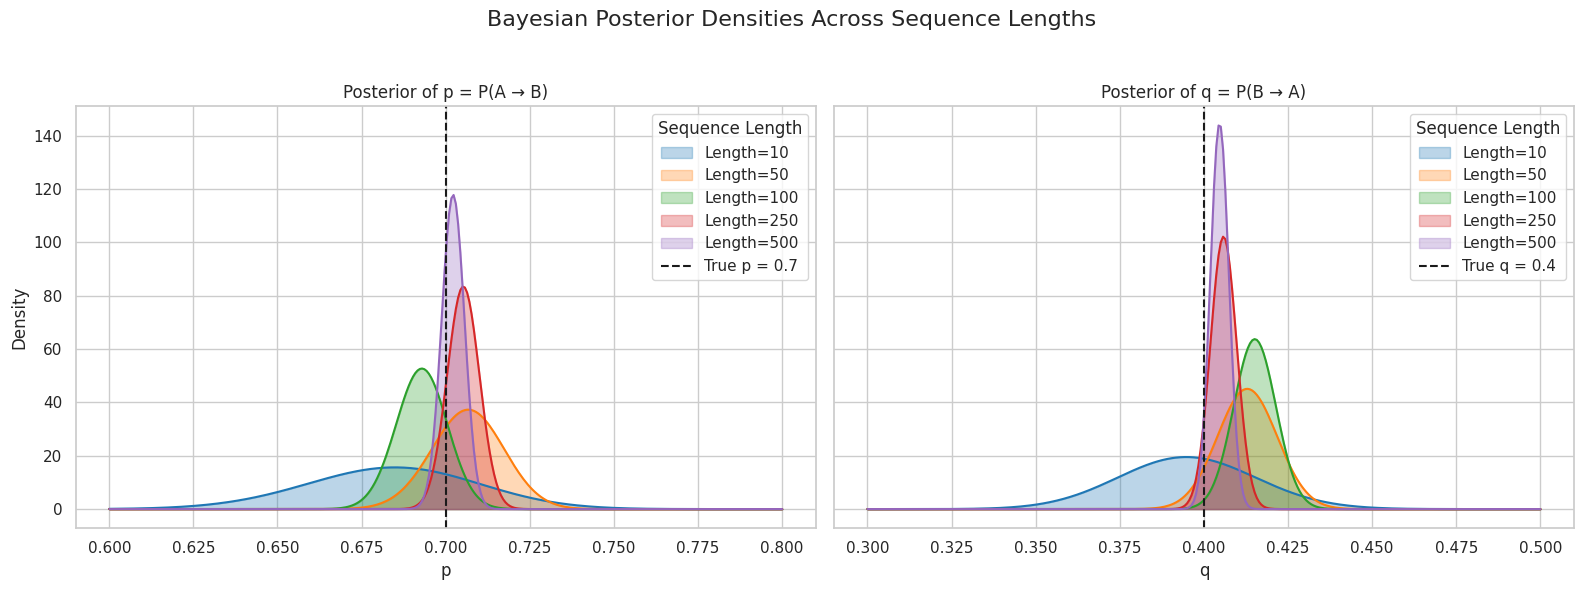

In [25]:
fig, axes = plot_posterior_distribution(posterior_p, posterior_q, hue='sequence', true_p=p_true, true_q=q_true)
plt.savefig("plots/posterior_distribution_sequences.png", dpi=300)
plt.show()

In [26]:
sequence_lengths = 100
num_chains = [10, 50, 100, 250, 500]

In [27]:
posterior_p, posterior_q = compute_posterior(
	alpha_prior_p, beta_prior_p, 
	alpha_prior_q, beta_prior_q, 
	num_chains, sequence_lengths)

In [28]:
# Print MAP estimate and credibility interval for each number of chains
for i, n_chains in enumerate(num_chains):
	alpha_p, beta_p = posterior_p[i]
	alpha_q, beta_q = posterior_q[i]
	
	credibility_p = credibility_interval(alpha_p, beta_p)
	credibility_q = credibility_interval(alpha_q, beta_q)
	
	print(f"Number of Chains {n_chains}:")
	print(f"  MAP estimate for p: {alpha_p / (alpha_p + beta_p):.3f}, Credibility Interval: {credibility_p}")
	print(f"  MAP estimate for q: {alpha_q / (alpha_q + beta_q):.3f}, Credibility Interval: {credibility_q}")

Number of Chains 10:
  MAP estimate for p: 0.656, Credibility Interval: (0.6077908354750315, 0.7029921071970378)
  MAP estimate for q: 0.406, Credibility Interval: (0.3676564285471243, 0.4453213897511793)
Number of Chains 50:
  MAP estimate for p: 0.696, Credibility Interval: (0.6746716467545286, 0.7167494758683405)
  MAP estimate for q: 0.410, Credibility Interval: (0.3925464571092051, 0.4270566015656196)
Number of Chains 100:
  MAP estimate for p: 0.683, Credibility Interval: (0.6674734050353478, 0.6976948346260872)
  MAP estimate for q: 0.397, Credibility Interval: (0.3849740307260529, 0.40921060401426157)
Number of Chains 250:
  MAP estimate for p: 0.697, Credibility Interval: (0.6874565134130972, 0.706426994448218)
  MAP estimate for q: 0.399, Credibility Interval: (0.3916492671248514, 0.40695167063608956)
Number of Chains 500:
  MAP estimate for p: 0.701, Credibility Interval: (0.6940576481733407, 0.7074183007312509)
  MAP estimate for q: 0.402, Credibility Interval: (0.396685691

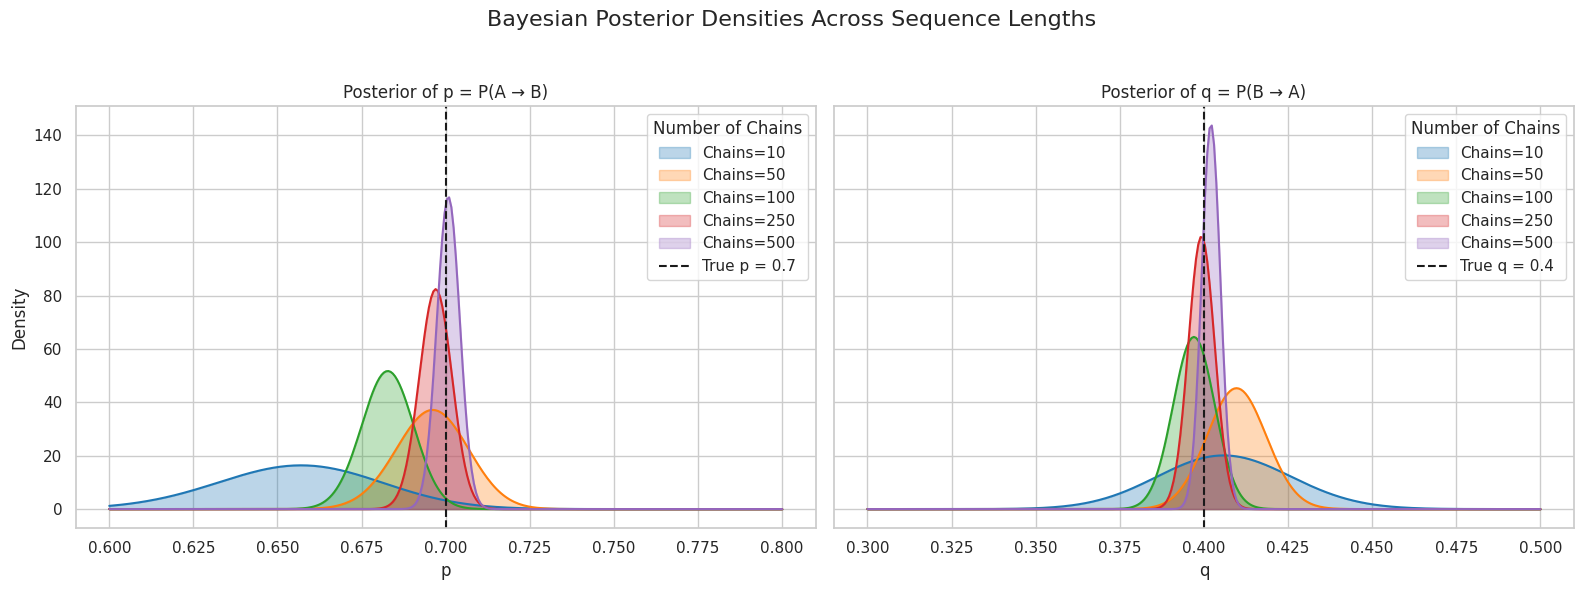

In [29]:
fig, axes = plot_posterior_distribution(posterior_p, posterior_q, hue='chains', true_p=p_true, true_q=q_true)
plt.savefig("plots/posterior_distribution_chains.png", dpi=300)
plt.show()